In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn
import pyBigWig
from tqdm.auto import tqdm


## Peak level analysis

In [2]:
# In this section, we will make 2 plots:
# 1. A bar plot comparing the number of peaks in motif_pos, motif_neg, chip and atac
# 2. A venn diagram demonstrating the overlap between ATAC peaks with motif in it and ChIP peaks.


In [2]:
# cell_type = "HepG2"
# tf = "FOXA1"
# profile = "MA0148.4"

# motif_peak_path = f"./data_jaspar/track/hg38/{profile}.bb"
# chip_seq_peak_path = f"./data/{cell_type}/{tf}/ENCSR267DFA_rep12_ENCFF600IFL.bigBed"
# atac_seq_peak_path = f"./data/{cell_type}/ATAC-seq/ENCSR291GJU_rep123_ENCFF186ECK.bigBed"


In [13]:
# def count_num_peaks(bigbed_path, chrs: list = None, strand=None) -> int:
#     bb = pyBigWig.open(bigbed_path)
#     num_peaks = 0
#     chroms = bb.chroms()
#     for chrom, length in chroms.items():
#         if chrs is None or chrom in chrs:
#             if strand is None:
#                 entries = bb.entries(chrom, 0, length)
#             else:
#                 entries = [
#                     0 for i in bb.entries(chrom, 0, length) if f"\t{strand}" in i[2]
#                 ]
#             num_peaks += len(entries)
#     return num_peaks


In [3]:
# num_peak_motif_pos = count_num_peaks(motif_peak_path, strand="+")
# num_peak_motif_neg = count_num_peaks(motif_peak_path, strand="-")
# num_peak_chip = count_num_peaks(chip_seq_peak_path)
# num_peak_atac = count_num_peaks(atac_seq_peak_path)


In [2]:
cell_type = "HepG2"
tf = "FOXA1"
profile = "MA0148.4"

motif_peak_path = f"./data_jaspar/track/hg38/{profile}.bed"
chip_seq_peak_path = f"./data/{cell_type}/{tf}/ENCSR267DFA_rep12_ENCFF600IFL.bed"
atac_seq_peak_path = f"./data/{cell_type}/ATAC-seq/ENCSR291GJU_rep123_ENCFF186ECK.bed"

motif_peak_df = pd.read_csv(motif_peak_path, sep="\t", header=None)
motif_peak_df.columns = ["chr", "start", "end", "name", "score", "strand"]
motif_pos_peak_df = motif_peak_df[motif_peak_df["strand"] == "+"]
motif_neg_peak_df = motif_peak_df[motif_peak_df["strand"] == "-"]
chip_peak_df = pd.read_csv(chip_seq_peak_path, sep="\t", header=None)
chip_peak_df.columns = [
    "chr",
    "start",
    "end",
    "name",
    "score",
    "strand",
    "signalValue",
    "pValue",
    "qValue",
    "peak",
]
atac_peak_df = pd.read_csv(atac_seq_peak_path, sep="\t", header=None)
atac_peak_df.columns = [
    "chr",
    "start",
    "end",
    "name",
    "score",
    "strand",
    "signalValue",
    "pValue",
    "qValue",
    "peak",
]


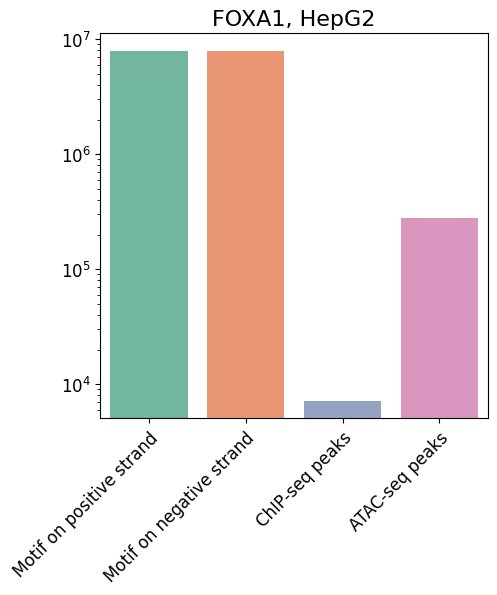

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
# set a color palette
sns.set_palette("Set2")
sns.barplot(
    x=["motif_pos", "motif_neg", "chip", "atac"],
    y=[
        len(motif_pos_peak_df),
        len(motif_neg_peak_df),
        len(chip_peak_df),
        len(atac_peak_df),
    ],
    ax=ax,
)
# better x tick labels
ax.set_xticklabels(
    [
        "Motif on positive strand",
        "Motif on negative strand",
        "ChIP-seq peaks",
        "ATAC-seq peaks",
    ]
)
# rotate x tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(f"{tf}, {cell_type}", fontsize=16)
# log scale on y axis
ax.set_yscale("log")
# bigger tick labels
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
plt.show()


In [6]:
# Sort the DataFrames by "chr" and "start" columns
motif_peak_df = motif_peak_df.sort_values(["chr", "start"]).reset_index(drop=True)
chip_peak_df = chip_peak_df.sort_values(["chr", "start"]).reset_index(drop=True)
atac_peak_df = atac_peak_df.sort_values(["chr", "start"]).reset_index(drop=True)

# Create an IntervalIndex for motif_peak_df and chip_peak_df
motif_intervals = pd.IntervalIndex.from_arrays(
    motif_peak_df["start"], motif_peak_df["end"], closed="both"
)
chip_intervals = pd.IntervalIndex.from_arrays(
    chip_peak_df["start"], chip_peak_df["end"], closed="both"
)

In [7]:
# motif_in_atac_peak = np.zeros(len(atac_peak_df), dtype=bool)
# atac_peak_overlap_chip_peak = np.zeros(len(atac_peak_df), dtype=bool)
# for i, row in tqdm(atac_peak_df.iterrows()):
#     motif_in_peak = np.logical_and(
#         motif_peak_df["chr"] == row["chr"],
#         motif_peak_df["start"] >= row["start"],
#         motif_peak_df["end"] <= row["end"],
#     )
#     motif_in_atac_peak[i] = np.any(motif_in_peak)
#     chip_peak_overlap = np.logical_and(
#         chip_peak_df["chr"] == row["chr"],
#         np.logical_or(
#             np.logical_and(
#                 chip_peak_df["start"] >= row["start"],
#                 chip_peak_df["start"] <= row["end"],
#             ),
#             np.logical_and(
#                 chip_peak_df["end"] >= row["start"], chip_peak_df["end"] <= row["end"]
#             ),
#         ),
#     )
#     atac_peak_overlap_chip_peak[i] = np.any(chip_peak_overlap)

# atac_peak_df["peak_has_motif"] = motif_in_atac_peak
# atac_peak_df["overlap_chip_seq_peak"] = atac_peak_overlap_chip_peak


In [9]:
# Precompute indices for each chromosome
def precompute_chr_indices(df):
    unique_chrs = df["chr"].unique()
    chr_indices = {}
    for chr_value in unique_chrs:
        left = np.searchsorted(df["chr"], chr_value, side="left")
        right = np.searchsorted(df["chr"], chr_value, side="right")
        chr_indices[chr_value] = (left, right)
    return chr_indices


motif_chr_indices = precompute_chr_indices(motif_peak_df)
chip_chr_indices = precompute_chr_indices(chip_peak_df)


In [11]:
# Initialize the output arrays
motif_in_atac_peak = np.zeros(len(atac_peak_df), dtype=bool)
atac_peak_overlap_chip_peak = np.zeros(len(atac_peak_df), dtype=bool)
motif_length = motif_peak_df["end"].iloc[0] - motif_peak_df["start"].iloc[0]

# Iterate over atac_peak_df
for i, row in tqdm(atac_peak_df.iterrows(), total=len(atac_peak_df)):
    atac_interval = pd.Interval(row["start"], row["end"], closed="both")
    shrunk_atac_interval = pd.Interval(
        row["start"] + motif_length, row["end"] - motif_length, closed="both"
    )

    # Get the precomputed indices for the current "chr" value in motif_peak_df and chip_peak_df
    motif_chr_idx = motif_chr_indices.get(row["chr"], (0, 0))
    chip_chr_idx = chip_chr_indices.get(row["chr"], (0, 0))

    # Check if there's any overlap between the ATAC-seq peak and motif_peak_df
    # motif_in_atac_peak[i] = any(
    #     motif_intervals[motif_chr_idx[0] : motif_chr_idx[1]].overlaps(atac_interval)
    # )
    motif_in_atac_peak[i] = any(
        motif_intervals[motif_chr_idx[0] : motif_chr_idx[1]].overlaps(
            shrunk_atac_interval
        )
    )

    # Check if there's any overlap between the ATAC-seq peak and chip_peak_df
    atac_peak_overlap_chip_peak[i] = any(
        chip_intervals[chip_chr_idx[0] : chip_chr_idx[1]].overlaps(atac_interval)
    )

# Add the results as new columns to atac_peak_df
atac_peak_df["peak_has_motif"] = motif_in_atac_peak
atac_peak_df["overlap_chip_seq_peak"] = atac_peak_overlap_chip_peak


  0%|          | 0/279739 [00:00<?, ?it/s]

In [12]:
np.save("atac_peak_overlap_motif.npy", atac_peak_df.peak_has_motif.values)
np.save("atac_peak_overlap_chip_seq.npy", atac_peak_df.overlap_chip_seq_peak.values)


In [13]:
atac_peak_df.peak_has_motif.sum()


221563

In [14]:
atac_peak_df.overlap_chip_seq_peak.sum()


11443

In [15]:
np.logical_and(atac_peak_df.peak_has_motif, atac_peak_df.overlap_chip_seq_peak).sum()


11268

In [16]:
len(chip_peak_df)


7149

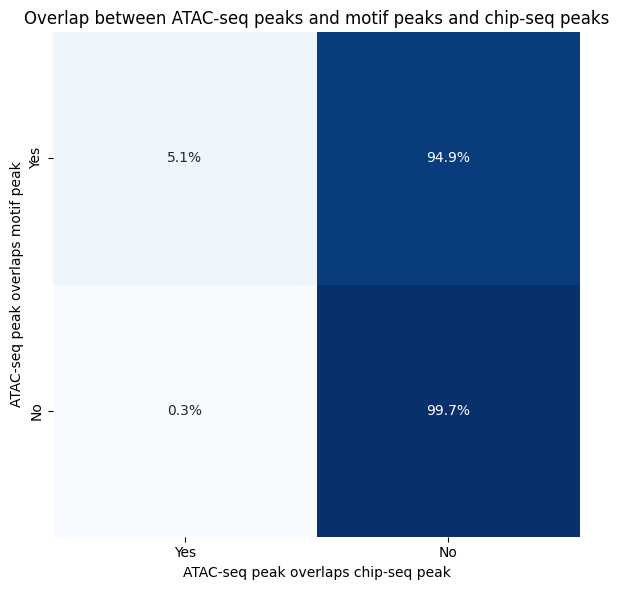

In [23]:
# make a 2x2 heatmap of the overlap between ATAC-seq peaks and motif peaks
# and ATAC-seq peaks and chip-seq peaks
fig, ax = plt.subplots(figsize=(6, 6))
data = pd.crosstab(atac_peak_df.peak_has_motif, atac_peak_df.overlap_chip_seq_peak)
# reorder the rows and columns
data = data.reindex([True, False])
data = data.reindex(columns=[True, False])
data = data / data.sum(axis=1).values[:, None]

# (normalize by row and show percentage)
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("ATAC-seq peak overlaps chip-seq peak")
ax.set_ylabel("ATAC-seq peak overlaps motif peak")
ax.set_xticklabels(["Yes", "No"])
ax.set_yticklabels(["Yes", "No"])
ax.set_title("Overlap between ATAC-seq peaks and motif peaks and chip-seq peaks")
fig.tight_layout()
fig.show()
# fig.savefig("atac_peak_overlap_motif_chip_seq.png", dpi=300, bbox_inches="tight")


## Window level analysis

In [8]:
data_dir = "/home/ubuntu/project_comp/data_window"


In [9]:
cell_type = "HepG2"
tf = "FOXA1"
window_size = 200
step_size = 20
temperature = 200
offset = 800


In [10]:
atac_files = [
    f"{data_dir}/{cell_type}/ATAC-seq/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/ATAC-seq")
    if i.startswith(f"{window_size}_{step_size}")
]
chip_files = [
    f"{data_dir}/{cell_type}/{tf}/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/{tf}")
    if i.startswith(f"{window_size}_{step_size}")
]
motif_pos_file = f"{data_dir}/motif/hg38/{tf}/{window_size}_{step_size}_{temperature}_{offset}_pos.npz"
motif_neg_file = f"{data_dir}/motif/hg38/{tf}/{window_size}_{step_size}_{temperature}_{offset}_neg.npz"


In [11]:
atac_file = atac_files[0]
chip_file = chip_files[0]

atac = np.load(atac_file)
chip = np.load(chip_file)
motif_pos = np.load(motif_pos_file)
motif_neg = np.load(motif_neg_file)


In [31]:
chr_ = "chr6"


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression


In [52]:
# Select the arrays for the specified chromosome
chromosome = "chr6"
atac_seq_data = atac[chromosome]
chip_seq_data = chip[chromosome]
motif_scan_pos_data = motif_pos[chromosome]
motif_scan_neg_data = motif_neg[chromosome]

# Create a DataFrame
data = pd.DataFrame(
    {
        "ATAC_seq": atac_seq_data,
        "ChIP_seq": chip_seq_data,
        "Motif_scan_pos": motif_scan_pos_data,
        "Motif_scan_neg": motif_scan_neg_data,
    }
)

# Drop rows with NaN values
data = data.dropna().query("ATAC_seq > 1e-5")

# Calculate the quantile bins and drop duplicate edges
quantiles = pd.qcut(data["ATAC_seq"], q=50, duplicates="drop")

# Get the unique bin labels
unique_bin_labels = quantiles.cat.categories
data["Quantile"] = quantiles.cat.rename_categories(range(1, len(unique_bin_labels) + 1))

print(data.Quantile.unique().shape)

intercepts = []
slopes = []

# Fit linear model for each bin and store the intercepts
for bin_label in tqdm(data["Quantile"].unique()):
    bin_data = data[data["Quantile"] == bin_label]
    # filter to only consider data points with top 1% ChIP-seq
    # bin_data = bin_data[bin_data.ChIP_seq > np.quantile(bin_data.ChIP_seq, 0.99)]
    X = (bin_data["Motif_scan_pos"] + bin_data["Motif_scan_neg"]).values.reshape(-1, 1)
    # X = np.minimum(bin_data['Motif_scan_pos'], bin_data['Motif_scan_neg']).values.reshape(-1, 1)
    y = bin_data["ChIP_seq"]

    # Initialize linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    intercepts.append(lin_reg.intercept_)
    slopes.append(lin_reg.coef_[0])


(49,)


  0%|          | 0/49 [00:00<?, ?it/s]

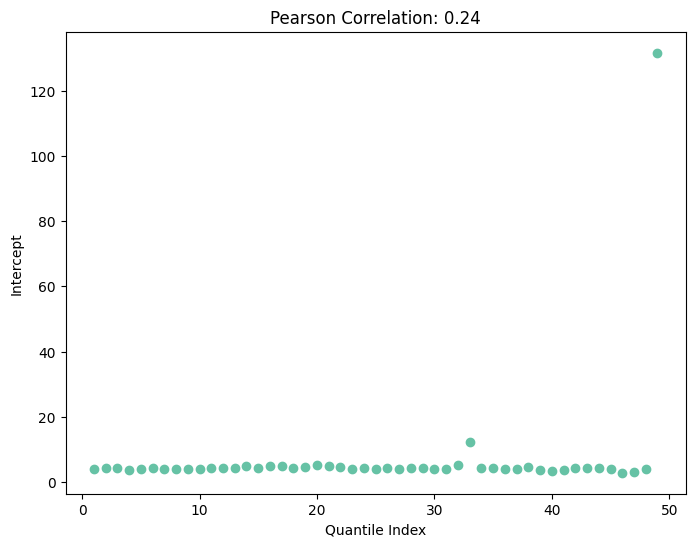

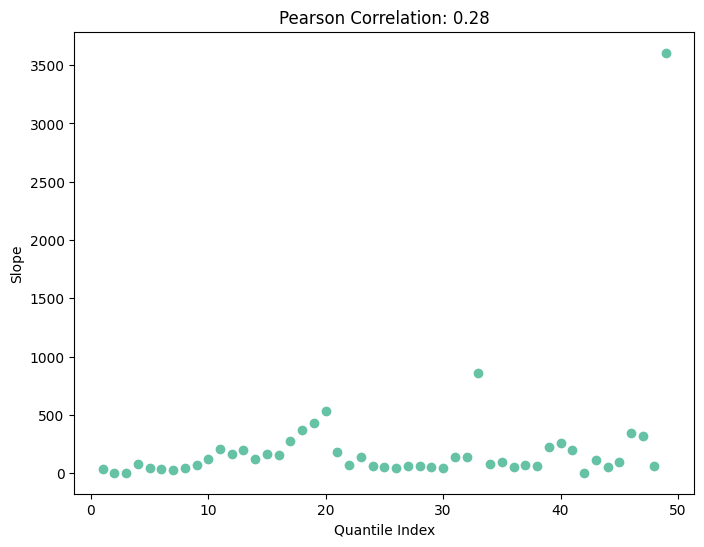

In [127]:
# Plot the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(1, len(unique_bin_labels) + 1), intercepts)
ax.set_xlabel("Quantile Index")
ax.set_ylabel("Intercept")

# Calculate Pearson correlation
corr, _ = pearsonr(range(1, len(unique_bin_labels) + 1), intercepts)
ax.set_title(f"Pearson Correlation: {corr:.2f}")

# Show the plot
fig.show()

# make a similar one for slope
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(1, len(unique_bin_labels) + 1), slopes)
ax.set_xlabel("Quantile Index")
ax.set_ylabel("Slope")
corr, _ = pearsonr(range(1, len(unique_bin_labels) + 1), slopes)
ax.set_title(f"Pearson Correlation: {corr:.2f}")
fig.show()


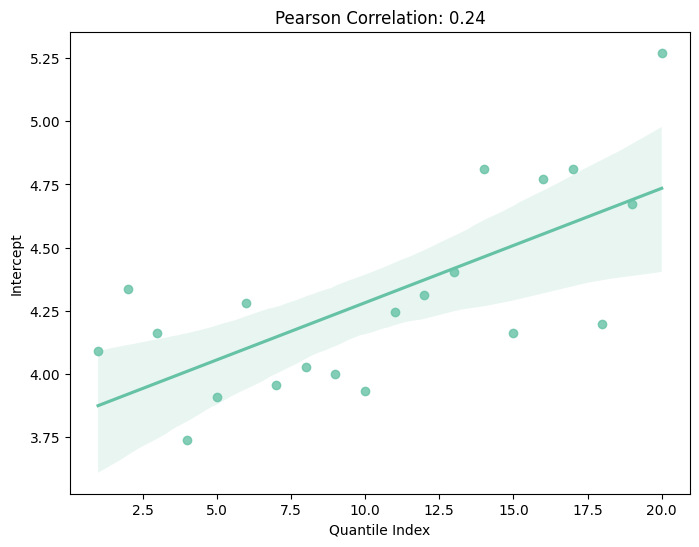

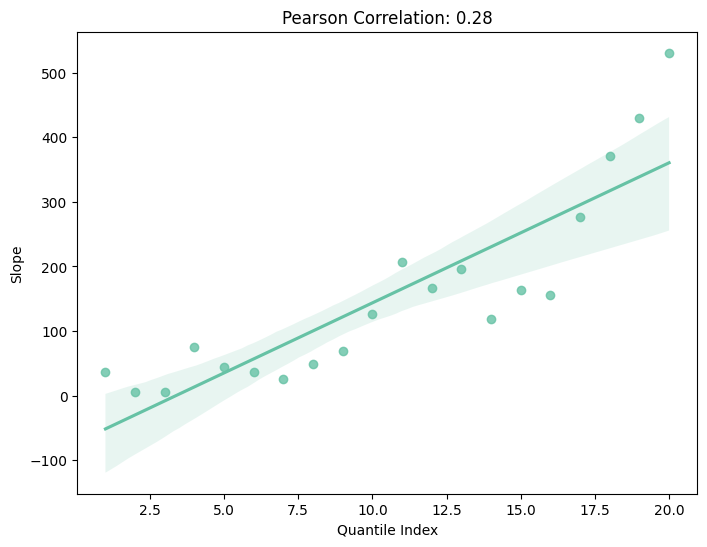

In [134]:
# exclude the last data point
x = np.arange(1, len(unique_bin_labels) + 1)[:20]
y = intercepts[:20]
# Plot the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=x, y=y, ax=ax)
ax.set_xlabel("Quantile Index")
ax.set_ylabel("Intercept")

# Calculate Pearson correlation
corr, _ = pearsonr(range(1, len(unique_bin_labels) + 1), intercepts)
ax.set_title(f"Pearson Correlation: {corr:.2f}")

# Show the plot
fig.show()

# make a similar one for slope
x = np.arange(1, len(unique_bin_labels) + 1)[:20]
y = slopes[:20]
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=x, y=y, ax=ax)
ax.set_xlabel("Quantile Index")
ax.set_ylabel("Slope")
corr, _ = pearsonr(range(1, len(unique_bin_labels) + 1), slopes)
ax.set_title(f"Pearson Correlation: {corr:.2f}")
fig.show()


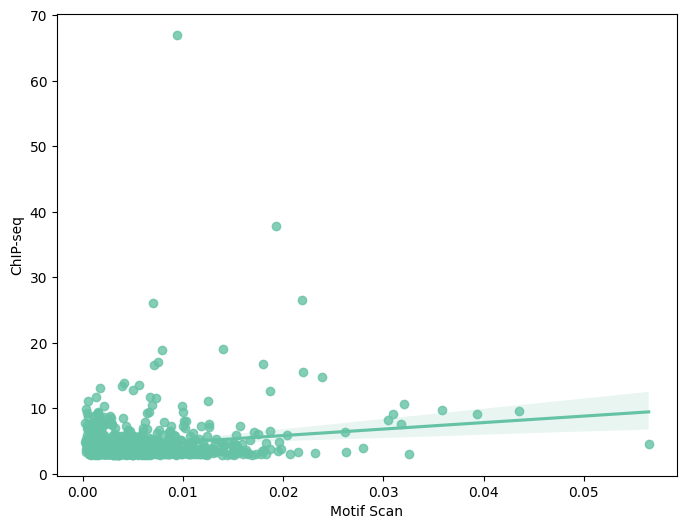

In [132]:
# plot a scatter plot with a linear regression line for the 42th quantile
bin_data = data[data["Quantile"] == 21]
bin_data = bin_data[bin_data.ChIP_seq > np.quantile(bin_data.ChIP_seq, 0.99)]
X = (bin_data["Motif_scan_pos"] + bin_data["Motif_scan_neg"]).values.reshape(-1, 1)
y = bin_data["ChIP_seq"]
# y = np.exp(bin_data['ChIP_seq'] / 20)
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=X, y=y, ax=ax)
# ax.set_xscale('log')
ax.set_xlabel("Motif Scan")
ax.set_ylabel("ChIP-seq")
fig.show()


In [57]:
data.shape

(4525273, 5)

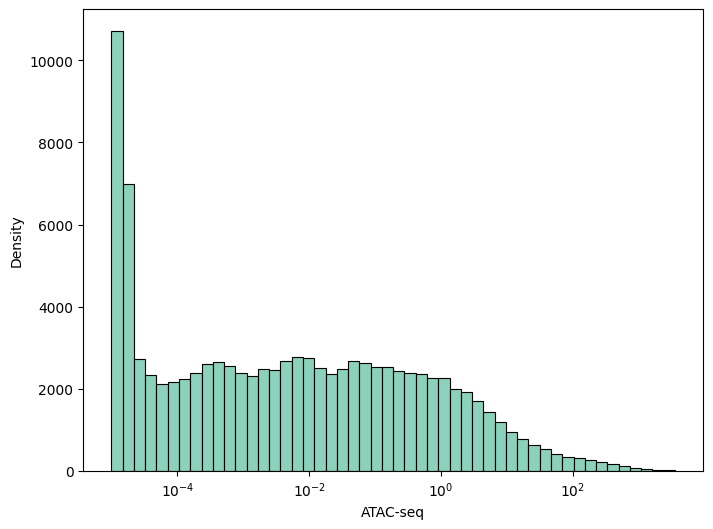

In [61]:
# dist plot for ATAC-seq on chr6
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data.sample(100000)["ATAC_seq"], ax=ax, bins=50, log_scale=True)
ax.set_xlabel("ATAC-seq")
ax.set_ylabel("Density")
fig.show()


In [47]:
# Select the arrays for the specified chromosome
def get_coor(chromosome, bed: pd.DataFrame = None, element: str = None):
    
    atac_seq_data = atac[chromosome]
    chip_seq_data = chip[chromosome]
    motif_scan_pos_data = motif_pos[chromosome]
    motif_scan_neg_data = motif_neg[chromosome]

    starts = np.arange(0, len(atac_seq_data) * step_size, step_size)
    ends = starts + window_size

    if bed is not None:
        # only keep those overlap with one of the elements in the bed file
        bed = bed[bed.chrom == chromosome]
        starts_window_idx = bed.start // step_size
        ends_window_idx = np.ceil(bed.end / step_size).astype(int)
        idx = np.concatenate([np.arange(x, y) for x, y in zip(starts_window_idx, ends_window_idx)])
        # bed_intervals = pd.IntervalIndex.from_arrays(bed.start, bed.end, closed="left")
        # data_intervals = pd.IntervalIndex.from_arrays(starts, ends, closed="left")
        # has_overlap = [any(bed_intervals.overlaps(x)) for x in tqdm(data_intervals)]
        # atac_seq_data = atac_seq_data[has_overlap]
        # chip_seq_data = chip_seq_data[has_overlap]
        # motif_scan_pos_data = motif_scan_pos_data[has_overlap]
        # motif_scan_neg_data = motif_scan_neg_data[has_overlap]
        atac_seq_data = atac_seq_data[idx]
        chip_seq_data = chip_seq_data[idx]
        motif_scan_pos_data = motif_scan_pos_data[idx]
        motif_scan_neg_data = motif_scan_neg_data[idx]

    # Create a DataFrame
    data = pd.DataFrame(
        {
            "ATAC_seq": atac_seq_data,
            "ChIP_seq": chip_seq_data,
            "Motif_scan_pos": motif_scan_pos_data,
            "Motif_scan_neg": motif_scan_neg_data,
        }
    )

    # Drop rows with NaN values
    data = data.dropna().query("ATAC_seq > 1e-5")

    # Calculate the quantile bins and drop duplicate edges
    quantiles = pd.qcut(data["ATAC_seq"], q=50, duplicates="drop")

    # Get the unique bin labels
    unique_bin_labels = quantiles.cat.categories
    data["Quantile"] = quantiles.cat.rename_categories(
        range(1, len(unique_bin_labels) + 1)
    )

    # print(data.Quantile.unique().shape)

    intercepts = []
    slopes = []

    # Fit linear model for each bin and store the intercepts
    for bin_label in tqdm(data["Quantile"].unique()):
        bin_data = data[data["Quantile"] == bin_label]
        # filter to only consider data points with top 1% ChIP-seq
        # bin_data = bin_data[bin_data.ChIP_seq > np.quantile(bin_data.ChIP_seq, 0.99)]
        X = (bin_data["Motif_scan_pos"] + bin_data["Motif_scan_neg"]).values.reshape(
            -1, 1
        )
        # X = np.minimum(bin_data['Motif_scan_pos'], bin_data['Motif_scan_neg']).values.reshape(-1, 1)
        y = bin_data["ChIP_seq"]

        # Initialize linear regression model
        lin_reg = LinearRegression()
        lin_reg.fit(X, y)
        intercepts.append(lin_reg.intercept_)
        slopes.append(lin_reg.coef_[0])

    # Plot the scatter plot
    # fig, ax = plt.subplots(figsize=(8, 6))
    # ax.scatter(range(1, len(unique_bin_labels) + 1), intercepts)
    # ax.set_xlabel('Quantile Index')
    # ax.set_ylabel('Intercept')

    # # Calculate Pearson correlation
    # corr, _ = pearsonr(range(1, len(unique_bin_labels) + 1), intercepts)
    # ax.set_title(f'Pearson Correlation: {corr:.2f}')

    # # Show the plot
    # fig.show()

    # make a similar one for slope
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.arange(1, len(unique_bin_labels) + 1)
    y = slopes
    ax.scatter(x, y)
    ax.set_xlabel("Quantile Index")
    ax.set_ylabel("Slope")
    corr, _ = pearsonr(x, y)
    ax.set_title(f"Pearson Correlation: {corr:.2f}")
    fig.savefig(f"./figs/{chromosome}_{element}_slopes.png")
    plt.close(fig)
    return corr


In [25]:
sns.set_palette("Set2")

In [28]:
promoter_df = pd.read_table("/home/ubuntu/project_comp/data_screen/HepG2/HepG2.promoters.bed")
enhancer_df = pd.read_table("/home/ubuntu/project_comp/data_screen/HepG2/HepG2.enhancers.bed")
ctcf_df = pd.read_table("/home/ubuntu/project_comp/data_screen/HepG2/HepG2.CTCF.bed")

In [30]:
promoter_df.columns = ["chrom", "start", "end", "name", "score", "strand", "7", "8", "9", "10", "11"]
enhancer_df.columns = ["chrom", "start", "end", "name", "score", "strand", "7", "8", "9", "10", "11"]
ctcf_df.columns = ["chrom", "start", "end", "name", "score", "strand", "7", "8", "9", "10", "11"]

In [48]:
corrs = {}
for chr_ in set(motif_pos.keys()) & set(atac.keys()):
    corrs[chr_] = get_coor(chr_)

corrs_promoter = {}
for chr_ in set(motif_pos.keys()) & set(atac.keys()):
    corrs_promoter[chr_] = get_coor(chr_, promoter_df, "promoter")

corrs_enhancer = {}
for chr_ in set(motif_pos.keys()) & set(atac.keys()):
    corrs_enhancer[chr_] = get_coor(chr_, enhancer_df, "enhancer")

corrs_ctcf = {}
for chr_ in set(motif_pos.keys()) & set(atac.keys()):
    corrs_ctcf[chr_] = get_coor(chr_, ctcf_df, "ctcf")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


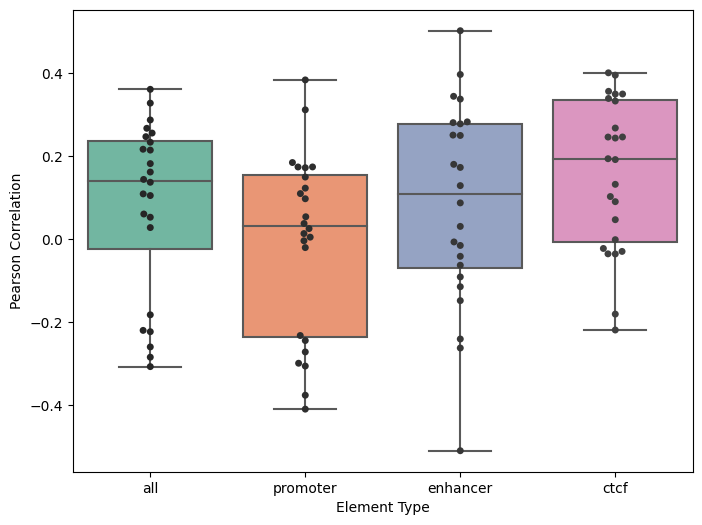

In [56]:
# make a box plot with scatter. there are 4 boxex for 4 different types of elements
# and each box has 25 points for 25 chromosomes
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    data=pd.DataFrame(
        {
            "all": list(corrs.values()),
            "promoter": list(corrs_promoter.values()),
            "enhancer": list(corrs_enhancer.values()),
            "ctcf": list(corrs_ctcf.values()),
        }
    ),
    ax=ax,
)
sns.swarmplot(
    data=pd.DataFrame(
        {
            "all": list(corrs.values()),
            "promoter": list(corrs_promoter.values()),
            "enhancer": list(corrs_enhancer.values()),
            "ctcf": list(corrs_ctcf.values()),
        }
    ),
    ax=ax,
    color=".25",
)

ax.set_ylabel("Pearson Correlation")
ax.set_xlabel("Element Type")
fig.savefig("./figs/element_type.png")


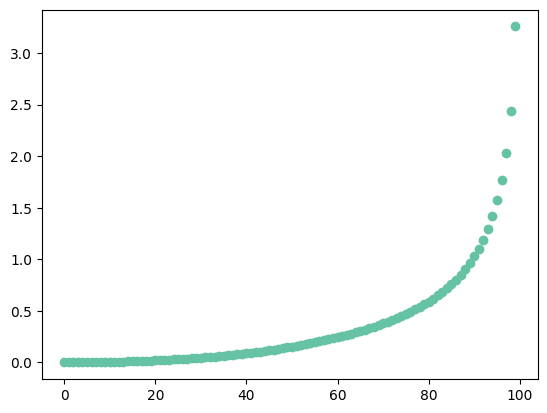

In [118]:
# percentiles of ChIP-seq
chip_seq_percentiles = np.percentile(data["ChIP_seq"], np.arange(0, 100, 1))
plt.scatter(np.arange(0, 100, 1), chip_seq_percentiles)


In [62]:
(data.ATAC_seq == data.ATAC_seq.min()).sum()


162005

In [65]:
data.shape


(7883187, 5)

In [66]:
162005 / 7883187


0.020550698594362916

In [82]:
# get percentiles of ATAC-seq data
atac_seq_percentiles = np.percentile(data.ATAC_seq, np.arange(0, 101, 1))
atac_seq_percentiles


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 9.99999975e-06,
       9.99999975e-06, 9.99999975e-06, 9.99999975e-06, 1.00155230e-05,
       1.01143207e-05, 1.03801940e-05, 1.09273742e-05, 1.18757477e-05,
       1.33894953e-05, 1.56903742e-05, 1.90980827e-05, 1.99999995e-05,
       1.99999995e-05, 2.35882460e-05, 3.01640928e-05, 4.03177579e-05,
      

In [85]:
(data.ATAC_seq > 1e-5).sum() / data.shape[0]


0.5740410572526061

In [94]:
bin_data.shape[0] / data.shape[0]


0.019999898348674213

In [43]:
data.Quantile.sort_index().value_counts()


1     3357914
10     173953
4       78850
39      78833
45      78832
32      78832
33      78832
34      78832
35      78832
36      78832
38      78832
41      78832
42      78832
43      78832
47      78832
46      78832
29      78832
48      78832
49      78832
50      78832
52      78832
53      78832
54      78832
55      78832
56      78832
57      78832
31      78832
58      78832
28      78832
12      78832
14      78832
15      78832
9       78832
17      78832
18      78832
19      78832
8       78832
20      78832
21      78832
7       78832
22      78832
24      78832
25      78832
26      78832
27      78832
13      78832
6       78831
51      78831
44      78831
16      78831
40      78831
37      78831
23      78831
30      78831
5       78815
3       77924
11      62542
2       32764
Name: Quantile, dtype: int64

In [14]:
# only keep those that are not nan in all
keep = np.logical_and.reduce(
    [
        np.logical_not(np.isnan(atac[chr_])),
        np.logical_not(np.isnan(chip[chr_])),
        np.logical_not(np.isnan(motif_neg[chr_])),
        np.logical_not(np.isnan(motif_pos[chr_])),
    ]
)
atac_chr = atac[chr_][keep]
chip_chr = chip[chr_][keep]
motif_neg_chr = motif_neg[chr_][keep]
motif_pos_chr = motif_pos[chr_][keep]
print(atac_chr.shape, chip_chr.shape, motif_neg_chr.shape, motif_pos_chr.shape)


(6223632,) (6223632,) (6223632,) (6223632,)


In [15]:
atac_chr.shape, chip_chr.shape, motif_pos_chr.shape, motif_neg_chr.shape


((6223632,), (6223632,), (6223632,), (6223632,))

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


(array([6.155965e+06, 2.658000e+04, 1.229300e+04, 7.395000e+03,
        4.947000e+03, 3.490000e+03, 2.543000e+03, 2.000000e+03,
        1.539000e+03, 1.238000e+03, 9.360000e+02, 8.120000e+02,
        6.680000e+02, 5.560000e+02, 4.320000e+02, 3.620000e+02,
        2.990000e+02, 2.440000e+02, 1.950000e+02, 1.680000e+02,
        1.630000e+02, 1.220000e+02, 1.080000e+02, 8.600000e+01,
        6.900000e+01, 6.200000e+01, 5.500000e+01, 3.600000e+01,
        3.700000e+01, 3.400000e+01, 2.600000e+01, 3.400000e+01,
        1.600000e+01, 1.500000e+01, 1.100000e+01, 2.200000e+01,
        6.000000e+00, 6.000000e+00, 2.000000e+00, 4.000000e+00,
        2.000000e+00, 4.000000e+00, 5.000000e+00, 6.000000e+00,
        3.000000e+00, 3.000000e+00, 2.000000e+00, 5.000000e+00,
        0.000000e+00, 3.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 2.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

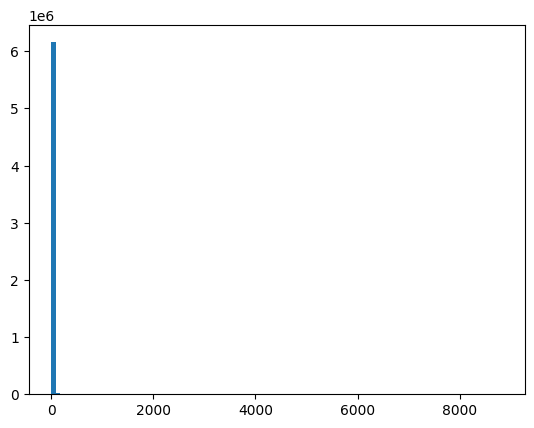

In [17]:
# distribution of atac data
plt.hist(atac_chr, bins=100)


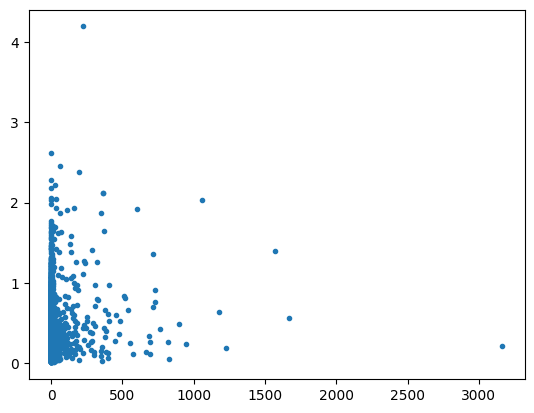

In [18]:
sample = np.random.choice(atac_chr.shape[0], 10000)
# chip vs atac, log scale on x
fig, ax = plt.subplots()
ax.plot(atac_chr[sample], chip_chr[sample], ".")


In [19]:
# plot a violin plot that partition chip-seq signal to 0~0.2, 0.2~0.4, 0.4~0.6, 0.6~0.8, 0.8~, and y axis is atac-seq signal
bins = np.arange(0, 1, 0.2)


In [20]:
bins


array([0. , 0.2, 0.4, 0.6, 0.8])

<AxesSubplot: >

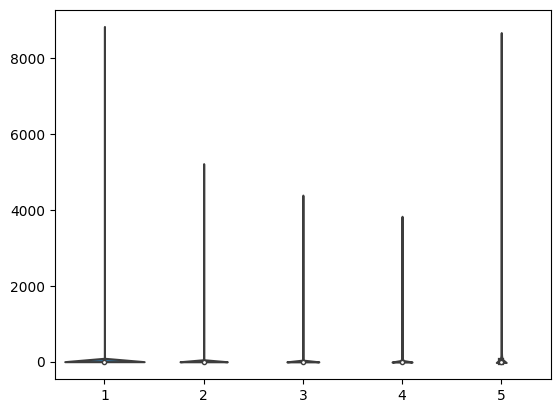

In [21]:
sns.violinplot(x=np.digitize(chip_chr, bins), y=atac_chr)


In [22]:
(np.digitize(chip_chr, bins) == 5).sum(), (chip_chr >= 0.8).sum()


(246301, 246301)

<AxesSubplot: >

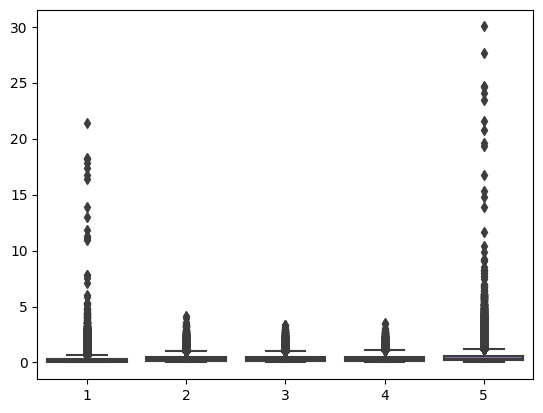

In [23]:
# partition atac-seq signal to 0~0.5, 0.5~1.0, 1.0~1.5, 1.5~2.0, >= 2.0
bins = np.arange(0, 2.5, 0.5)
sns.boxplot(x=np.digitize(atac_chr, bins), y=chip_chr)


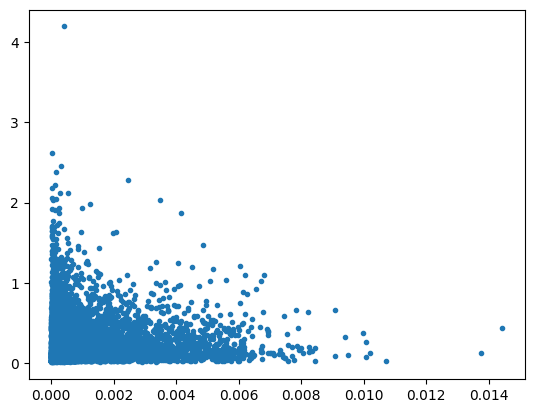

In [24]:
# chip vs motif_pos
plt.plot(motif_pos[chr_][sample], chip[chr_][sample], ".")


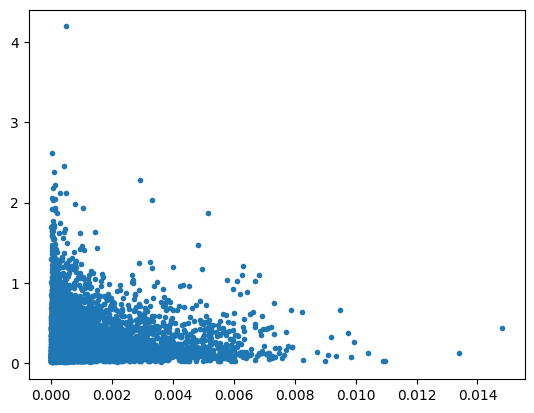

In [25]:
# chip vs motif_neg
plt.plot(motif_neg[chr_][sample], chip[chr_][sample], ".")


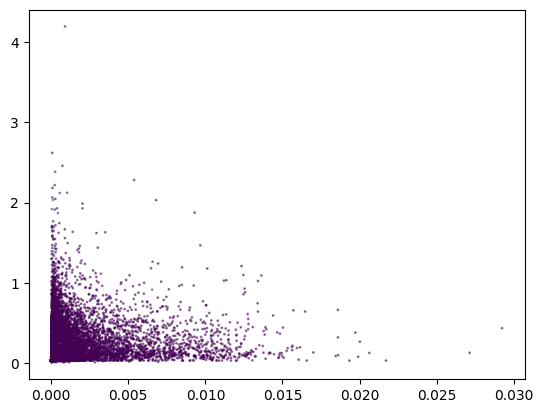

In [26]:
# chip vs motif_neg + motif_pos, colored by atac
plt.scatter(
    motif_neg[chr_][sample] + motif_pos[chr_][sample],
    chip[chr_][sample],
    c=atac[chr_][sample],
    cmap="viridis",
    alpha=0.5,
    s=1,
)


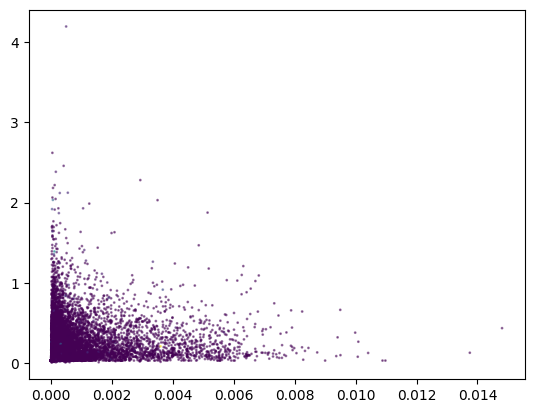

In [27]:
# chip vs max(motif_neg + motif_pos), colored by atac
plt.scatter(
    np.maximum(motif_neg[chr_][sample], motif_pos[chr_][sample]),
    chip[chr_][sample],
    c=atac[chr_][sample],
    cmap="viridis",
    alpha=0.5,
    s=1,
)


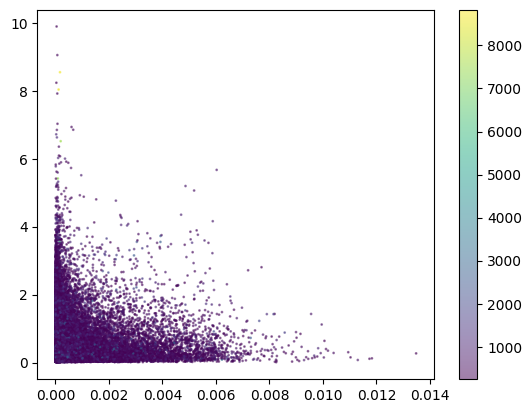

In [28]:
# get top 1% of ATAC-seq signal, plot chip vs max(motif_neg, motif_pos), colored by atac
top_atac = np.percentile(atac_chr, 99.5)
choose = atac_chr >= top_atac
plt.scatter(
    np.maximum(motif_neg_chr[choose], motif_pos_chr[choose]),
    chip_chr[choose],
    c=atac_chr[choose],
    cmap="viridis",
    alpha=0.5,
    s=1,
)
# give me a color bar
plt.colorbar()


In [29]:
import pyBigWig


In [30]:
bb = pyBigWig.open(
    "https://www.encodeproject.org/files/ENCFF094LQP/@@download/ENCFF094LQP.bigBed"
)


In [31]:
bb.header()


{'version': 4,
 'nLevels': 10,
 'nBasesCovered': 35920,
 'minVal': 1,
 'maxVal': 2,
 'sumData': 38400,
 'sumSquared': 43360}

In [32]:
# length of chr1 is 249250621
import pandas as pd

chr_size = pd.read_csv(
    "/home/ubuntu/s3/genomes/hg38/hg38.fa.sizes", sep="\t", header=None
)
chr2size = dict(zip(chr_size[0], chr_size[1]))


In [33]:
chr2size


{'chr1': 248956422,
 'chr10': 133797422,
 'chr11': 135086622,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr19': 58617616,
 'chr2': 242193529,
 'chr20': 64444167,
 'chr21': 46709983,
 'chr22': 50818468,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chr8': 145138636,
 'chr9': 138394717,
 'chrM': 16569,
 'chrX': 156040895,
 'chrY': 57227415}

In [34]:
num_peaks = 0
for chr_, size in bb.chroms().items():
    print(chr_, size)
    print(bb.entries(chr_, 0, size))
    num_peaks += len(bb.entries(chr_, 0, size))

num_peaks


chr1 248956422
[(154418217, 154418617, '.\t698\t.\t22.02114\t-1.00000\t0.17523\t200'), (155017270, 155017670, '.\t1000\t.\t34.30747\t-1.00000\t1.10037\t200'), (236096804, 236097204, '.\t1000\t.\t13.50951\t-1.00000\t0.06325\t200'), (236097135, 236097535, '.\t1000\t.\t9.16837\t-1.00000\t0.11014\t200')]
chr10 133797422
[(3886989, 3887389, '.\t1000\t.\t27.33446\t-1.00000\t0.77499\t200'), (46524603, 46525003, '.\t1000\t.\t58.55536\t-1.00000\t1.65321\t200'), (74056287, 74056687, '.\t1000\t.\t34.14231\t-1.00000\t1.11394\t200')]
chr11 135086622
[(65502881, 65503281, '.\t747\t.\t16.87098\t-1.00000\t-0.05600\t200'), (65504081, 65504481, '.\t740\t.\t21.72360\t-1.00000\t0.13892\t200'), (65504290, 65504690, '.\t732\t.\t8.89417\t-1.00000\t0.10366\t200'), (114162847, 114163247, '.\t943\t.\t26.53616\t-1.00000\t0.63491\t200')]
chr12 133275309
[(52280267, 52280667, '.\t655\t.\t22.83567\t-1.00000\t0.28369\t200'), (65649018, 65649418, '.\t865\t.\t25.69729\t-1.00000\t0.55898\t200')]
chr14 107043718
[(35403

96

In [35]:
import numpy as np
import matplotlib.pyplot as plt


In [36]:
def gaussian_kernel(window_size, sigma=1):
    x = np.arange(-(window_size - 1) / 2, (window_size - 1) / 2 + 1, 1)
    g = np.exp(-((x**2) / (2 * sigma**2)))
    return g / g.sum()


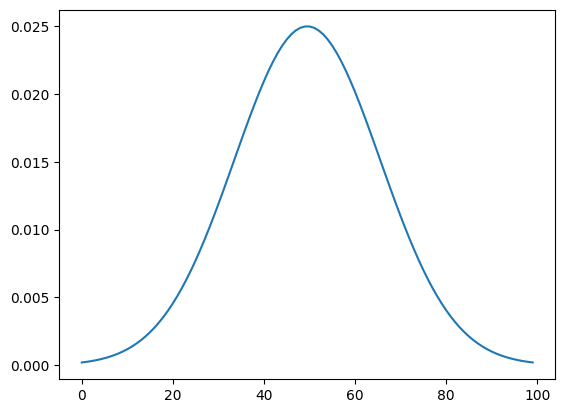

In [37]:
window_size = 100
plt.plot(gaussian_kernel(100, window_size // 6))
